In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 100 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=a3f83aaad77371da28d12fe710306e127a8946f2b11505ce32b9cd5acd07ab0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkj51edx/wheels/55/59/29/0fb1c635652

In [6]:
from dul_2021.utils.hw12_utils import *

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [19]:
import contextlib
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, stride):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, (3, 3), stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(out_ch)
        self.dropout = nn.Dropout(0.4)
        self.act = nn.LeakyReLU(0.3)

    def forward(self, x):
        return self.act(self.dropout(self.norm(self.conv(x))))


class ImageClassifier(nn.Module):
    def __init__(self, n_classes, latent_dim=128):
        super().__init__()
        self.blocks = nn.Sequential(
            Block(3, 16, stride=2),
            Block(16, 32, stride=2),
            Block(32, 64, stride=2),
            Block(64, 128, stride=2),
            Block(128, 128, stride=2).conv,
        )
        self.linear = nn.Linear(128, latent_dim)
        self.batch_norm = nn.BatchNorm1d(latent_dim)
        self.leaky_relu = nn.LeakyReLU(1e-2)
        self.classifier = nn.Linear(latent_dim, n_classes)

    def forward(self, batched_images):
        convolved = self.blocks(batched_images)
        encoded = self.linear(convolved.view(batched_images.shape[0], -1))
        hidden = self.leaky_relu(self.batch_norm(encoded))
        return self.classifier(hidden)


class SemiSupervisedTrainer:
    def __init__(self, n_classes: int, latent_dim: int = 128, u_loss_weight: float = 1.0):
        self.model = ImageClassifier(n_classes, latent_dim).to(device)
        self.u_loss_weight = u_loss_weight

    def test(self, dataloader: DataLoader):
        self.model.eval()
        n_correct = 0
        total = 0
        for img, y in dataloader:
            img = img.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_pred = self.model(img).argmax(dim=-1)
                n_correct += (y == y_pred).sum().item()
                total += y.shape[0]
        return n_correct / total

    def unlabeled_loss(self, batched_images):
        raise NotImplementedError()

    def fit(self, train_dataloader, test_dataloader, n_epochs, lr=1e-3):
        optim = AdamW(self.model.parameters(), lr=lr)

        train_losses = []
        test_scores = [self.test(test_dataloader)]

        for i in range(n_epochs):
            postfix = {}
            self.model.train()
            for img, y in train_dataloader:
                img = img.to(device)
                y = y.to(device)

                unsupervised_loss = self.unlabeled_loss(img)

                labeled = y != -1
                model_output = self.model(img[labeled])
                ce_loss = F.cross_entropy(model_output, y[labeled])

                loss = ce_loss + self.u_loss_weight * unsupervised_loss

                optim.zero_grad()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5)
                loss.backward()
                optim.step()

                train_losses.append(loss.item())
                postfix["loss"] = train_losses[-1]

            test_scores.append(self.test(test_dataloader))
        return train_losses, test_scores


class VAT(SemiSupervisedTrainer):
    def __init__(self, n_classes, latent_dim=128, xi=10, alpha=1.0):
        super().__init__(n_classes, latent_dim, alpha)
        self.xi = xi

    @staticmethod
    @contextlib.contextmanager
    def _disable_tracking_bn_stats(model):
        def switch_attr(m):
            if hasattr(m, "track_running_stats"):
                m.track_running_stats ^= True

        model.apply(switch_attr)
        yield
        model.apply(switch_attr)

    def unlabeled_loss(self, batched_images: torch.Tensor):
        with torch.no_grad():
            pred = F.softmax(self.model(batched_images), dim=1)

        d = torch.normal(mean=0, std=1, size=batched_images.shape, device=device, requires_grad=True)

        with self._disable_tracking_bn_stats(self.model):
            pred_hat = self.model(batched_images + self.xi * d)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            adv_distance = F.kl_div(logp_hat, pred, reduction="batchmean")

            adv_distance.backward()
            r_adv = F.normalize(d.grad, dim=(1, 2, 3))
            self.model.zero_grad()

            pred_hat = self.model(batched_images + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            lds = F.kl_div(logp_hat, pred, reduction="batchmean")

        return lds



In [20]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256)

    vat = VAT(10, latent_dim=256)
    return vat.fit(train_dataloader, test_dataloader, n_epochs=15, lr=1e-4)

Files already downloaded and verified
Files already downloaded and verified


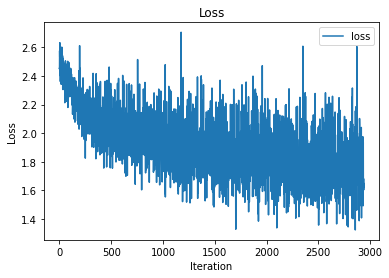

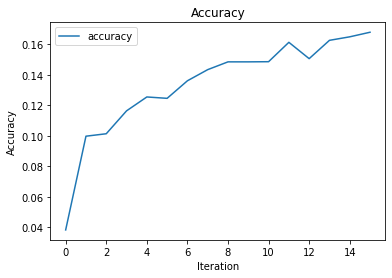

In [21]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [22]:

class FixMatch(SemiSupervisedTrainer):
    def __init__(self, n_classes, latent_dim=128, tau=0.95, lambda_u=1):
        super().__init__(n_classes, latent_dim, lambda_u)
        self.tau = tau

        self.strong_transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(size=32),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8
                ),
                transforms.RandomGrayscale(0.2),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        self.weak_transforms = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()])

    def unlabeled_loss(self, batched_images):
        with torch.no_grad():
            logits = self.model(self.weak_transforms(batched_images))
            probs = F.softmax(logits, dim=-1)
            confidence, pseudo_target = torch.max(probs, dim=-1)
            mask = confidence >= self.tau
        if mask.sum() == 0:
            return 0
        strong_out = self.model(self.strong_transforms(batched_images))
        loss = F.cross_entropy(strong_out[mask], pseudo_target[mask])
        return loss

In [23]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256)

    fix_match = FixMatch(10, latent_dim=128)

    return fix_match.fit(train_dataloader, test_dataloader, n_epochs=10, lr=1e-4)

Files already downloaded and verified
Files already downloaded and verified


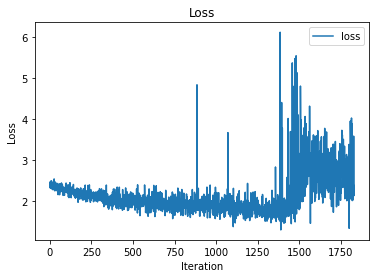

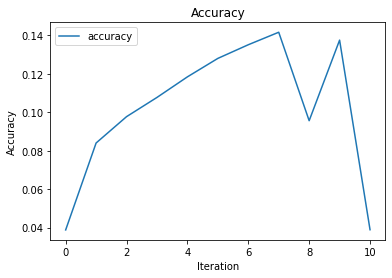

In [24]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """